In [1]:
#import libraries
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt 

#importing liabraries for graphical representation
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.cm import rainbow

#Packages for feature engineering
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

<b>Import Dataset</b>

In [2]:
travel = pd.read_csv('simulated_summary_total.csv')
# Dropping Feature Days because it remains fixed
travel.drop('Days',axis = 1, inplace=True)

In [3]:
travel.head(5)

,Vehicle,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,1,13114,152,56,0.005,SUV,0
1,2,18707,147,1,0.010,SUV,0
2,3,16659,151,127,0.019,Truck,0
3,4,13330,126,147,0.000,SUV,1
4,5,22533,10,11,0.001,Truck,0


Here, we plot a bar chart to visullay gauge the ratio of loss=0 and loss=1. it is mostly 0

Text(0.5, 1.0, 'Count of each Target Class')

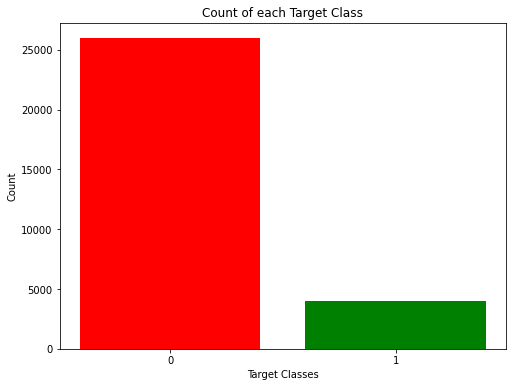

In [4]:
rcParams['figure.figsize'] = 8,6
plt.bar(travel['Loss'].unique(), travel['Loss'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

I then plotted histograms of different variables to look for outlier data points. According to the below charts, Hard brakes and Hard acceleration data clearly have a few very large data values that will be removed. The second series of histograms which are plotted after removing the outliers show a much smoother distribution of data

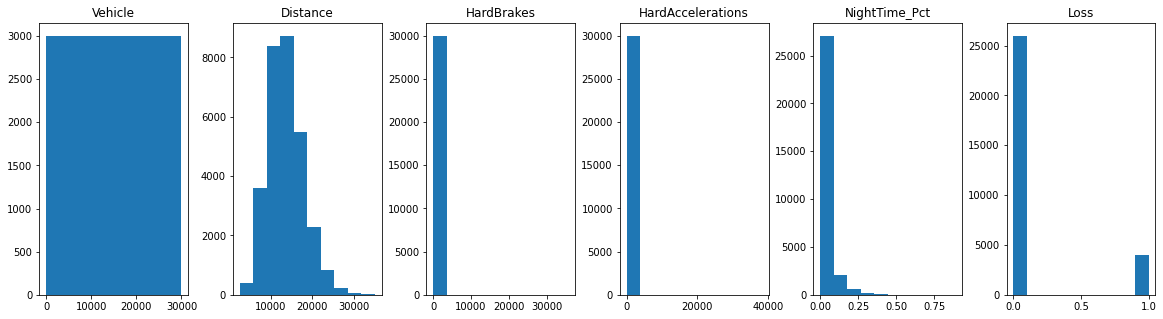

In [5]:
travel.hist(grid=False,sharex=False,sharey=False,figsize=(20,5),layout=(1,6))
plt.show()
# the plot shows that there are a few cars with very hard accelerations and brakes

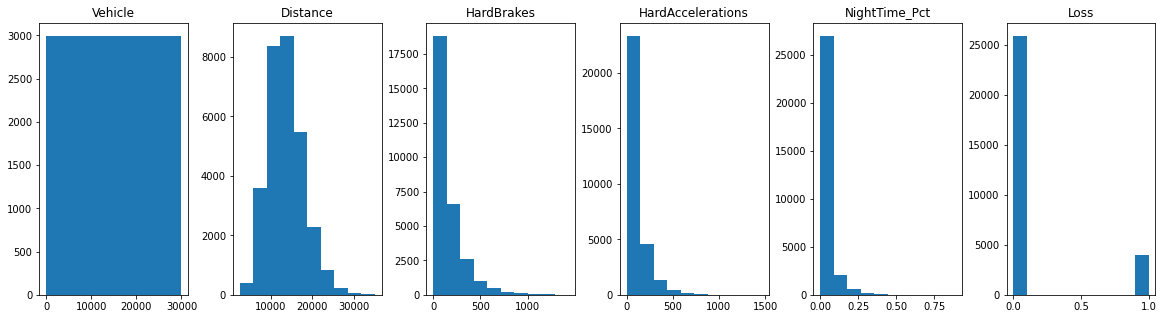

In [6]:
# remove very large data for Hard brakes and Hard acceleration. Set the threshold to 1500 harsh events
travel = travel[travel['HardAccelerations'] < 1500]
travel = travel[travel['HardBrakes'] < 1500]
travel.hist(grid=False,sharex=False,sharey=False,figsize=(20,5),layout=(1,6))
plt.show()

<b>Car types with maximum accident claims</b> I grouped the data based on the car type and plotted a bar chart to visually see the difference in terms of loss between types of cars. The var chart does not show a significance difference between vehicle types in terms of loss.

In [7]:
Claim_mean = travel.groupby('VehicleType', as_index=False)['Loss'].mean()
Claim_mean

,VehicleType,Loss
0,Car,0.124047
1,Minivan,0.102108
2,SUV,0.146905
3,Truck,0.138383


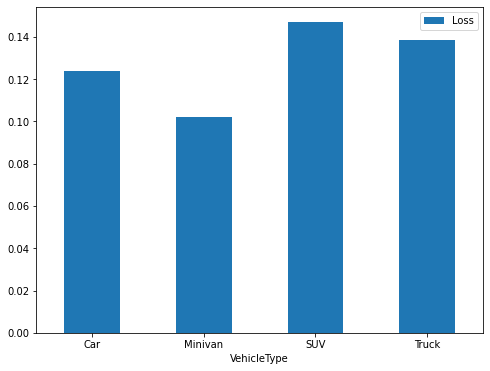

In [8]:
ax = Claim_mean.plot.bar(x='VehicleType', y='Loss', rot=0)

<b>Correlation of hard acceleartion and brakes with Loss</b>

We compute the correlation between hard accelerations/brakes and loss on each car type separately.
Pearson correlation values turn out to be small. I tested this on all four vehicle types (SUV, Minivan, Truck, Car). So, hard events are not imporatnt in predicting the risk.

In [9]:
carType = 'SUV'
groupData = travel.groupby('VehicleType')
carTypeData = groupData.get_group(carType).reset_index(drop=True)
carTypeData = carTypeData.drop({'Vehicle'}, axis = 1)
carTypeData.head(5)

,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,13114,152,56,0.005,SUV,0
1,18707,147,1,0.010,SUV,0
2,13330,126,147,0.000,SUV,1
3,17689,75,210,0.000,SUV,0
4,16008,116,92,0.000,SUV,1


In [10]:
HardAccelerations = carTypeData['HardAccelerations']
HardBrakes = carTypeData['HardBrakes']
Loss = carTypeData['Loss']
corrAcc = HardAccelerations.corr(Loss)
corrBrake = HardBrakes.corr(Loss)
corrAccBrake = HardBrakes.corr(HardAccelerations)
print('Correlation of Hrad Acceleration and Loss:  ', corrAcc)
print('Correlation of Hrad Brakes and Loss:        ', corrBrake)
print('Correlation of Hrad Brakes and Acceleration ', corrAccBrake)

Correlation of Hrad Acceleration and Loss:   0.07211317595930941
Correlation of Hrad Brakes and Loss:         -0.010206874271437984
Correlation of Hrad Brakes and Acceleration  0.08315216782421571


The above numbers show that the correlation of hard brakes and acceleration with loss are both minimal. However, hard accelerations have a higher correlation with loss compared to hard brakes. because 0.072 > 0.01. We now consider the correlation between all the involved variables.

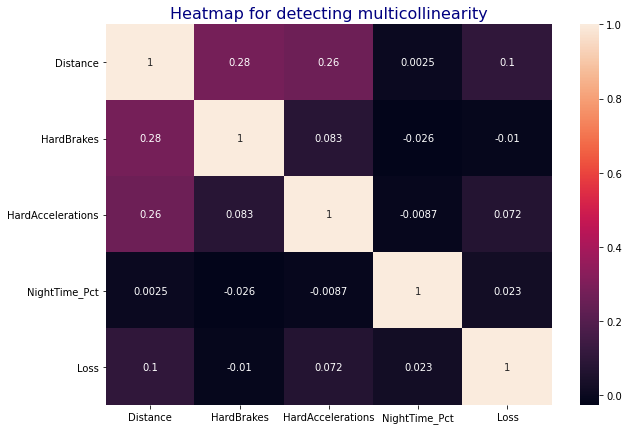

In [11]:
# this function does Multi colinearity detection -> correlation of all variables
def plot_heatmap(df, fig_size=(10, 7)):
    fig = plt.figure(figsize=fig_size)
    sns.heatmap(df.corr(), annot=True)
    plt.title('Heatmap for detecting multicollinearity', fontsize=16, color='navy')
    plt.show()
    
plot_heatmap(carTypeData)

<b>Inference</b>  From the above heat-map we can see that there is not a high correlation between any features and hence we can continue with all of the above features to train our model. One could argue that distance shows a higher correlartion with loss but it is still much smaller than corr = 1. 

<b> Train-Test Split </b> We will not group the data based on car type anymore. I considered all vehicle types together for building the model. Training and test data are split 70-30%. Random Forest and Logistic regression yield the same precsion at predicting risk.

In [12]:
X = travel.drop({'Loss','VehicleType', 'Vehicle'}, axis = 1)
Y = travel['Loss']
Y.head()
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7, random_state = 7)

<b> Random Forest classifier </b>

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)
print(accuracy_score(Y_test, y_pred_rf))
print(classification_report(Y_test, y_pred_rf))

0.8617886178861789
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      7759
           1       0.22      0.01      0.01      1220

    accuracy                           0.86      8979
   macro avg       0.54      0.50      0.47      8979
weighted avg       0.78      0.86      0.80      8979



<b> Logistic Regression </b>

In [14]:
logr = LogisticRegression()
logr.fit(X_train,Y_train)
y_pred = logr.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

0.8641274083973717
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      7759
           1       0.00      0.00      0.00      1220

    accuracy                           0.86      8979
   macro avg       0.43      0.50      0.46      8979
weighted avg       0.75      0.86      0.80      8979



C:\Users\mjsar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
